<a href="https://colab.research.google.com/github/sushmit86/Statiistical_rethinking_jax/blob/main/sushmit_05_geocentric_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# Install packages that are not installed in colab
try:
  import google.colab
  !pip install watermark
  !pip install jaxopt
except:
  pass

In [12]:
#@title import library
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
from tensorflow_probability.substrates import jax as tfp_jax
from collections import OrderedDict
tfd = tfp_jax.distributions
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import jaxopt
from jaxopt import ScipyMinimize
key = jax.random.PRNGKey(42)

def marginal_test_results(model, results, nll,credib_interval = 0.89, num_of_samples = 10000):
  '''
  model: tfp model like
  results: results from optimizing
  nll: negative log likelihood function
  credib_interval: the interval we are interested in
  num_of_samples: number of samples we want to get from the posterior distribution
  '''
  key = jax.random.PRNGKey(42)
  inv_hessian_matrix = jnp.linalg.inv(jax.hessian(nll)(results.params))
  mean_list = results.params
  sd_list = jnp.diagonal(inv_hessian_matrix)**(1/2)
  low_credib_interval = (1 - credib_interval)/2
  high_credib_interval = 1 - low_credib_interval
  parameter_list = []
  normal_dist = tfp_jax.distributions.Normal(loc=mean_list,scale =  sd_list)
  for _parameter in model.parameters['model']:
    if isinstance(model.parameters['model'][_parameter],tfp_jax.distributions.Distribution):
      try:
        _shape = model.parameters['model'][_parameter].event_shape[0]
        parameter_list.extend([_parameter + '_' +str(i) for i in range(0, _shape)])
      except:
        parameter_list.append(_parameter)

  df_result = pd.DataFrame({'mean': mean_list,
                           'sd':sd_list,
                            'low': normal_dist.quantile(low_credib_interval),
                            'high':tfp_jax.distributions.Normal(loc=mean_list,scale =  sd_list).quantile(high_credib_interval) },
                           index = parameter_list)
  post_dist = tfp_jax.distributions.MultivariateNormalFullCovariance(
    loc=results.params,covariance_matrix=inv_hessian_matrix )
  post_samples = post_dist.sample( sample_shape=num_of_samples,seed=key)
  df_post_samples = pd.DataFrame(post_samples,columns = parameter_list)
  return df_result,inv_hessian_matrix,df_post_samples

In [14]:
#@title 5.1
d = pd.read_csv('https://raw.githubusercontent.com/sushmit86/Statiistical_rethinking_jax/main/WaffleDivorce.csv',sep= ';')
d['A'] = (d.MedianAgeMarriage - d.MedianAgeMarriage.mean())/d.MedianAgeMarriage.std()
d['D'] = (d.Divorce - d.Divorce.mean())/d.Divorce.std()
d.head()
A_arr = jnp.array(d.A)
D_arr = jnp.array(d.D)

In [15]:
#@title 5.2
d.MedianAgeMarriage.std()

1.2436303013880823

In [18]:
#@title 5.3
model5_1 = tfd.JointDistributionNamedAutoBatched(OrderedDict(
    alpha = tfd.Normal(loc=0.0,scale=0.2),
    bA = tfd.Normal(loc=0.0,scale=0.5),
    sigma = tfd.Exponential(rate = 1.0),
    mu = lambda  alpha,bA,sigma: tfd.Deterministic(alpha + bA * A_arr),
    D = lambda mu,sigma: tfd.Sample(tfd.Normal(loc=mu,scale=sigma))
))
def nll5_1(parameters):
  samples = model5_1.sample(
      D = D_arr,
      alpha = parameters[0],
      bA = parameters[1],
      sigma = parameters[2],
      seed = jax.random.PRNGKey(42))
  return -1* model5_1.log_prob(samples)

x_arr =jnp.array([-2,2])

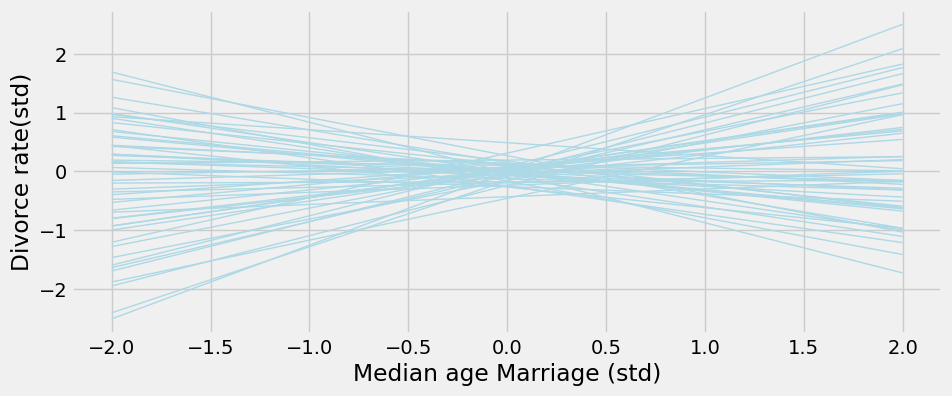

In [23]:
prior_samples =model5_1.sample(sample_shape= 50,seed = jax.random.PRNGKey(42))
fig, ax = plt.subplots(1,1,figsize=(10,4))
for _alpha,_bA in zip(prior_samples['alpha'],prior_samples['bA']):
  y_arr = _alpha + _bA * x_arr
  ax.plot(x_arr,y_arr,color = 'lightblue',linewidth=1)
ax.set_xlabel('Median age Marriage (std)')
ax.set_ylabel('Divorce rate(std)')
fig.show()

In [20]:
optimize_fn = ScipyMinimize(fun= nll5_1,method = 'L-BFGS-B' )
alpha_start = model5_1.parameters['model']['alpha'].mean()
bA_start = model5_1.parameters['model']['bA'].mean()
sigma_start = model5_1.parameters['model']['sigma'].mean()
results = optimize_fn.run(init_params=jnp.array([alpha_start,bA_start,sigma_start]))
df_result,cov_matrix,df_post_samples = marginal_test_results(model5_1,results,nll5_1)
df_result.round(3)

,mean,sd,low,high
alpha,0.000,0.097,-0.156,0.156
bA,-0.568,0.110,-0.744,-0.393
sigma,0.788,0.078,0.664,0.913
